# Свёрточные сети

## Настройка

Импорт необходимых библиотек, установка устройства и фиксация случайных зерен для воспроизводимости.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# У меня AMD, поэтому только cpu :(
device = torch.device('cpu')

# Фиксируем рандом для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)


## Загрузка данных

Загрузка и подготовка наборов данных MNIST и FashionMNIST
Будем загружать размерами пакетов по 64 и нормализовать изображения в диапазоне [0, 1].

In [2]:
# Преобразования изображений в тензоры для дальней работы
transform = transforms.Compose([
    transforms.ToTensor()
])

# Загрузка MNIST
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Загрузка FashionMNIST
fashion_train = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
fashion_test = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

# Создание загрузчиков данных
batch_size = 64

mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

fashion_train_loader = DataLoader(fashion_train, batch_size=batch_size, shuffle=True)
fashion_test_loader = DataLoader(fashion_test, batch_size=batch_size, shuffle=False)


100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%


## Определение модели

Определение сверточной сети с общей сверточной базой и двумя отдельными полносвязными головами для классификации MNIST и FashionMNIST.

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Общая сверточная база
        self.conv_base = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Первая голова для MNIST (10 классов)
        self.head1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        # Вторая голова для FashionMNIST (10 классов)
        self.head2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x, head='head1'):
        # Общие сверточные признаки
        features = self.conv_base(x)
        # Выбор головы
        if head == 'head1':
            return self.head1(features)
        elif head == 'head2':
            return self.head2(features)
        else:
            raise ValueError("Голова должна быть 'head1' или 'head2'")


## Обучение на MNIST

Обучаем сверточную нейронную сеть на наборе данных MNIST с построением графика обучения.

Эпоха 1/5 - Потеря (обучение): 0.1826, Точность (обучение): 0.9445, Потеря (тест): 0.0539, Точность (тест): 0.9828
Эпоха 2/5 - Потеря (обучение): 0.0488, Точность (обучение): 0.9848, Потеря (тест): 0.0324, Точность (тест): 0.9890
Эпоха 3/5 - Потеря (обучение): 0.0338, Точность (обучение): 0.9893, Потеря (тест): 0.0363, Точность (тест): 0.9873
Эпоха 4/5 - Потеря (обучение): 0.0250, Точность (обучение): 0.9922, Потеря (тест): 0.0311, Точность (тест): 0.9902
Эпоха 5/5 - Потеря (обучение): 0.0189, Точность (обучение): 0.9936, Потеря (тест): 0.0335, Точность (тест): 0.9884


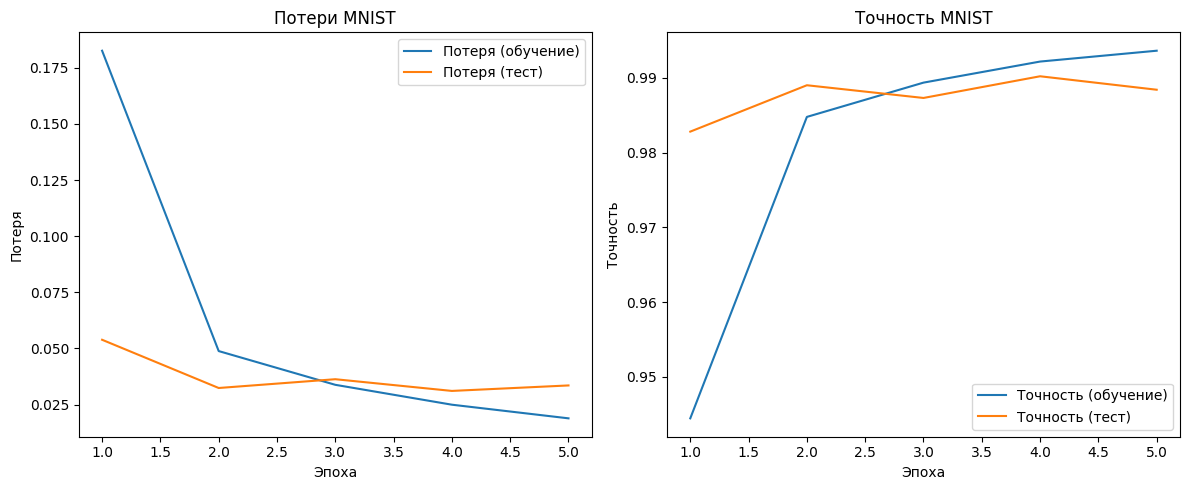

In [4]:
# Вспомогательные функции для обучения
def train(model, device, train_loader, optimizer, criterion, head):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, head=head)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, device, test_loader, criterion, head):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images, head=head)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Инициализация модели, функции потерь и оптимизатора для задачи MNIST
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model.conv_base.parameters()) + list(model.head1.parameters()), lr=1e-3)

# Обучение в течение заданных эпох
num_epochs = 5
train_losses_mnist, train_accs_mnist = [], []
test_losses_mnist, test_accs_mnist = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, mnist_train_loader, optimizer, criterion, head='head1')
    test_loss, test_acc = evaluate(model, device, mnist_test_loader, criterion, head='head1')
    train_losses_mnist.append(train_loss)
    train_accs_mnist.append(train_acc)
    test_losses_mnist.append(test_loss)
    test_accs_mnist.append(test_acc)
    print(f"Эпоха {epoch+1}/{num_epochs} - Потеря (обучение): {train_loss:.4f}, Точность (обучение): {train_acc:.4f}, Потеря (тест): {test_loss:.4f}, Точность (тест): {test_acc:.4f}")

# Построение графиков обучения для MNIST
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_mnist, label='Потеря (обучение)')
plt.plot(epochs, test_losses_mnist, label='Потеря (тест)')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('Потери MNIST')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs_mnist, label='Точность (обучение)')
plt.plot(epochs, test_accs_mnist, label='Точность (тест)')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность MNIST')
plt.legend()

plt.tight_layout()
plt.show()


## Сохранение начальных параметров

Сохраняем сверточную базу, первую голову (обученную) и вторую голову (необученную).

In [5]:
os.makedirs('saved_models', exist_ok=True)
torch.save(model.conv_base.state_dict(), 'saved_models/conv_base_initial.pth')
torch.save(model.head1.state_dict(), 'saved_models/head1_trained.pth')
torch.save(model.head2.state_dict(), 'saved_models/head2_initial.pth')
print("Параметры модели сохранены!")

Параметры модели сохранены!


## Обучение второй головы при замороженной сверточной базе

Замораживаем сверточную базу и обучаем только вторую голову на наборе данных FashionMNIST

Так же строим графики обучения для задачи FashionMNIST

Эпоха 1/5 - Потеря (обучение): 0.3852, Точность (обучение): 0.8648, Потеря (тест): 0.3369, Точность (тест): 0.8736
Эпоха 2/5 - Потеря (обучение): 0.2715, Точность (обучение): 0.9012, Потеря (тест): 0.2997, Точность (тест): 0.8862
Эпоха 3/5 - Потеря (обучение): 0.2311, Точность (обучение): 0.9150, Потеря (тест): 0.3098, Точность (тест): 0.8844
Эпоха 4/5 - Потеря (обучение): 0.2086, Точность (обучение): 0.9236, Потеря (тест): 0.2816, Точность (тест): 0.8955
Эпоха 5/5 - Потеря (обучение): 0.1865, Точность (обучение): 0.9306, Потеря (тест): 0.2811, Точность (тест): 0.8994


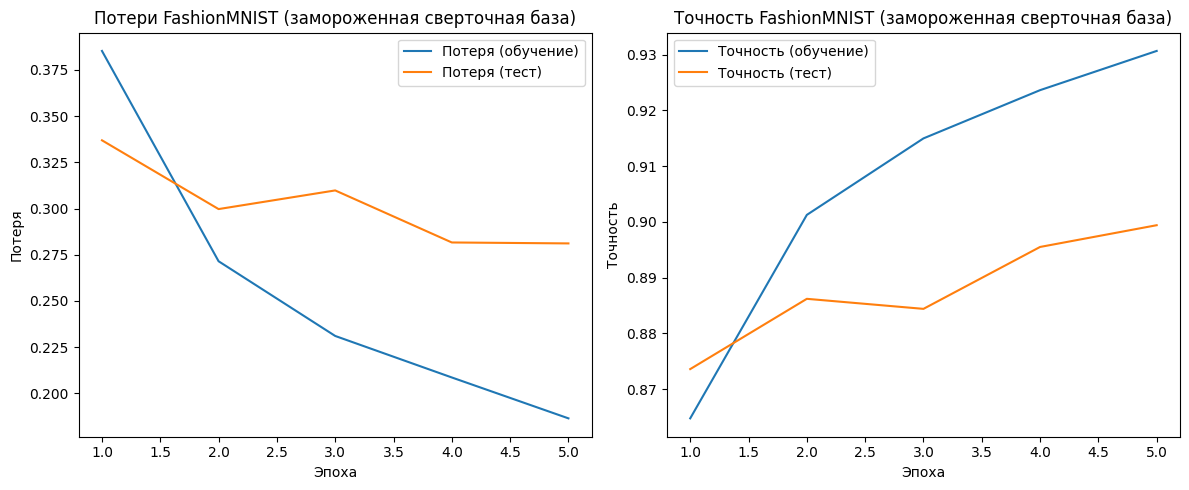

In [6]:
# Заморозка сверточной базы
for param in model.conv_base.parameters():
    param.requires_grad = False

# Определение оптимизатора только для head2
optimizer_head2 = optim.Adam(model.head2.parameters(), lr=1e-3)

# Обучение head2
num_epochs_head2 = 5
train_losses_fashion_frozen, train_accs_fashion_frozen = [], []
test_losses_fashion_frozen, test_accs_fashion_frozen = [], []

for epoch in range(num_epochs_head2):
    train_loss, train_acc = train(model, device, fashion_train_loader, optimizer_head2, criterion, head='head2')
    test_loss, test_acc = evaluate(model, device, fashion_test_loader, criterion, head='head2')
    train_losses_fashion_frozen.append(train_loss)
    train_accs_fashion_frozen.append(train_acc)
    test_losses_fashion_frozen.append(test_loss)
    test_accs_fashion_frozen.append(test_acc)
    print(f"Эпоха {epoch+1}/{num_epochs_head2} - Потеря (обучение): {train_loss:.4f}, Точность (обучение): {train_acc:.4f}, Потеря (тест): {test_loss:.4f}, Точность (тест): {test_acc:.4f}")

# Построение графиков обучения
epochs_fashion = range(1, num_epochs_head2 + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_fashion, train_losses_fashion_frozen, label='Потеря (обучение)')
plt.plot(epochs_fashion, test_losses_fashion_frozen, label='Потеря (тест)')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('Потери FashionMNIST (замороженная сверточная база)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_fashion, train_accs_fashion_frozen, label='Точность (обучение)')
plt.plot(epochs_fashion, test_accs_fashion_frozen, label='Точность (тест)')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность FashionMNIST (замороженная сверточная база)')
plt.legend()

plt.tight_layout()
plt.show()


## Дообучение второй головы (при разморозки сверточной базы)

Размораживаем сверточную базу и дообучаем вторую голову на FashionMNIST

Отслеживайте производительность на тестовых наборах MNIST и FashionMNIST с построением графиков

Эпоха 1/5 - Точность на тесте MNIST: 0.9883, Точность на тесте FashionMNIST: 0.9111
Эпоха 2/5 - Точность на тесте MNIST: 0.9883, Точность на тесте FashionMNIST: 0.9094
Эпоха 3/5 - Точность на тесте MNIST: 0.9885, Точность на тесте FashionMNIST: 0.9133
Эпоха 4/5 - Точность на тесте MNIST: 0.9882, Точность на тесте FashionMNIST: 0.9145
Эпоха 5/5 - Точность на тесте MNIST: 0.9882, Точность на тесте FashionMNIST: 0.9154


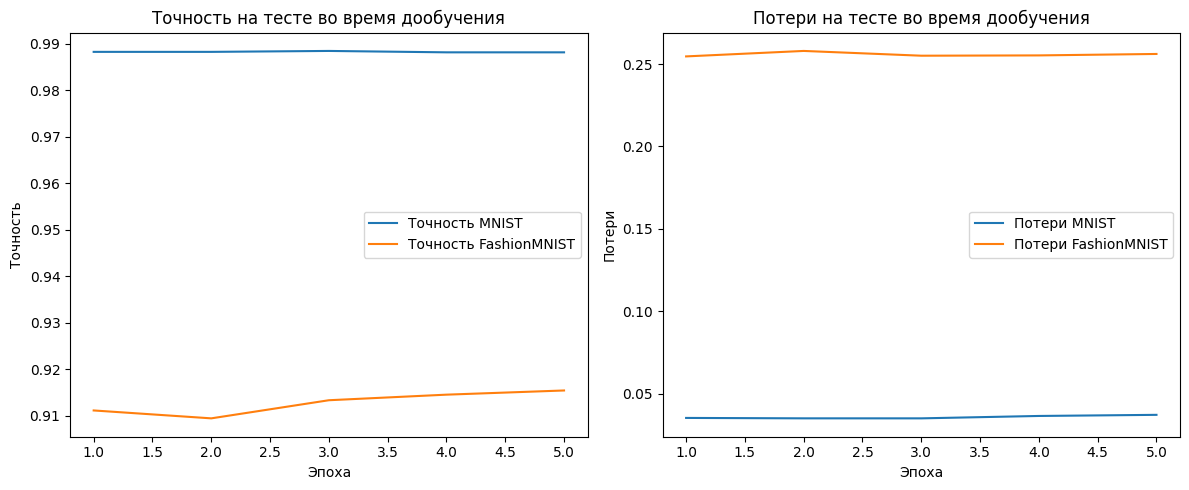

In [7]:
# Разморозка сверточной базы
for param in model.conv_base.parameters():
    param.requires_grad = True

# Определение оптимизатора для conv_base + head2
optimizer_finetune = optim.Adam(list(model.conv_base.parameters()) + list(model.head2.parameters()), lr=1e-4)

# Обучение и отслеживание обеих задач
num_epochs_finetune = 5
test_losses_mnist_finetune, test_accs_mnist_finetune = [], []
test_losses_fashion_finetune, test_accs_fashion_finetune = [], []

for epoch in range(num_epochs_finetune):
    train(model, device, fashion_train_loader, optimizer_finetune, criterion, head='head2')
    mnist_loss, mnist_acc = evaluate(model, device, mnist_test_loader, criterion, head='head1')
    fashion_loss, fashion_acc = evaluate(model, device, fashion_test_loader, criterion, head='head2')
    test_losses_mnist_finetune.append(mnist_loss)
    test_accs_mnist_finetune.append(mnist_acc)
    test_losses_fashion_finetune.append(fashion_loss)
    test_accs_fashion_finetune.append(fashion_acc)
    print(f"Эпоха {epoch+1}/{num_epochs_finetune} - Точность на тесте MNIST: {mnist_acc:.4f}, Точность на тесте FashionMNIST: {fashion_acc:.4f}")

# Построение графиков обучения для обеих задач
epochs_finetune = range(1, num_epochs_finetune + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_finetune, test_accs_mnist_finetune, label='Точность MNIST')
plt.plot(epochs_finetune, test_accs_fashion_finetune, label='Точность FashionMNIST')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность на тесте во время дообучения')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_finetune, test_losses_mnist_finetune, label='Потери MNIST')
plt.plot(epochs_finetune, test_losses_fashion_finetune, label='Потери FashionMNIST')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на тесте во время дообучения')
plt.legend()

plt.tight_layout()
plt.show()


## Обучение второй головы с нуля при размороженной сверточной базе

Загружаем сохраненные начальные параметры, размораживаем сверточную базу и обучаем вторую голову на FashionMNIST с нуля

Эпоха 1/5 - Точность на тесте MNIST: 0.9476, Точность на тесте FashionMNIST: 0.8691
Эпоха 2/5 - Точность на тесте MNIST: 0.9480, Точность на тесте FashionMNIST: 0.8852
Эпоха 3/5 - Точность на тесте MNIST: 0.9462, Точность на тесте FashionMNIST: 0.8879
Эпоха 4/5 - Точность на тесте MNIST: 0.9460, Точность на тесте FashionMNIST: 0.8821
Эпоха 5/5 - Точность на тесте MNIST: 0.9442, Точность на тесте FashionMNIST: 0.8967


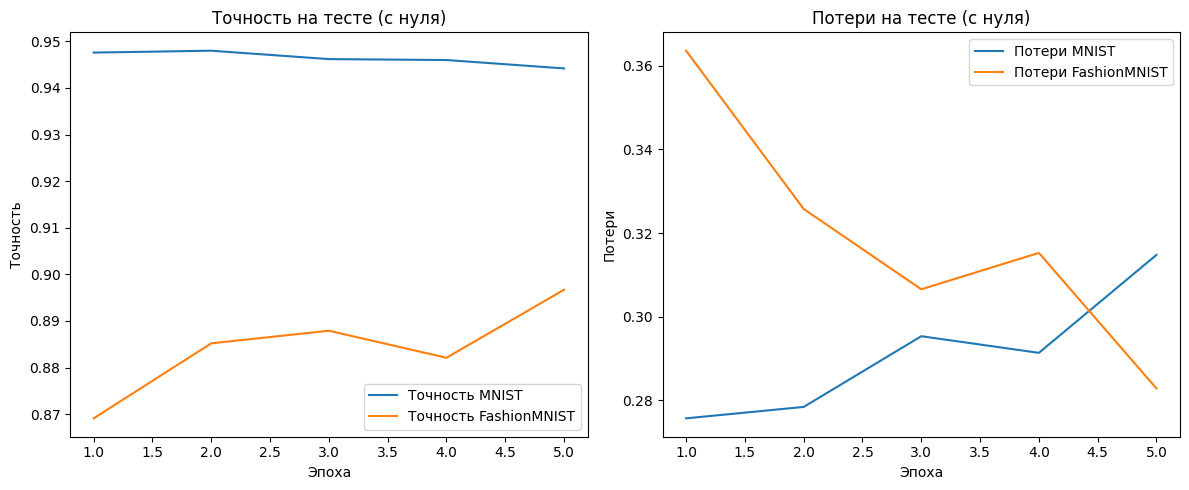

In [8]:
# Загрузка сохраненных начальных параметров
model = ConvNet().to(device)
model.conv_base.load_state_dict(torch.load('saved_models/conv_base_initial.pth'))
model.head1.load_state_dict(torch.load('saved_models/head1_trained.pth'))
model.head2.load_state_dict(torch.load('saved_models/head2_initial.pth'))

# Разморозка всех параметров
for param in model.parameters():
    param.requires_grad = True

# Определение оптимизатора для conv_base + head2
optimizer_scratch = optim.Adam(list(model.conv_base.parameters()) + list(model.head2.parameters()), lr=1e-4)

# Обучение с нуля и отслеживание обеих задач
num_epochs_scratch = 5
test_losses_mnist_scratch, test_accs_mnist_scratch = [], []
test_losses_fashion_scratch, test_accs_fashion_scratch = [], []

for epoch in range(num_epochs_scratch):
    train(model, device, fashion_train_loader, optimizer_scratch, criterion, head='head2')
    mnist_loss, mnist_acc = evaluate(model, device, mnist_test_loader, criterion, head='head1')
    fashion_loss, fashion_acc = evaluate(model, device, fashion_test_loader, criterion, head='head2')
    test_losses_mnist_scratch.append(mnist_loss)
    test_accs_mnist_scratch.append(mnist_acc)
    test_losses_fashion_scratch.append(fashion_loss)
    test_accs_fashion_scratch.append(fashion_acc)
    print(f"Эпоха {epoch+1}/{num_epochs_scratch} - Точность на тесте MNIST: {mnist_acc:.4f}, Точность на тесте FashionMNIST: {fashion_acc:.4f}")

# Построение графиков обучения
epochs_scratch = range(1, num_epochs_scratch + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_scratch, test_accs_mnist_scratch, label='Точность MNIST')
plt.plot(epochs_scratch, test_accs_fashion_scratch, label='Точность FashionMNIST')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность на тесте (с нуля)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_scratch, test_losses_mnist_scratch, label='Потери MNIST')
plt.plot(epochs_scratch, test_losses_fashion_scratch, label='Потери FashionMNIST')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на тесте (с нуля)')
plt.legend()

plt.tight_layout()
plt.show()


## Поиск наиболее похожих изображений между классами в FashionMNIST

Для каждой пары классов (c, t) в тестовом наборе FashionMNIST находим изображение класса c, которое модель считает наиболее вероятным для класса t

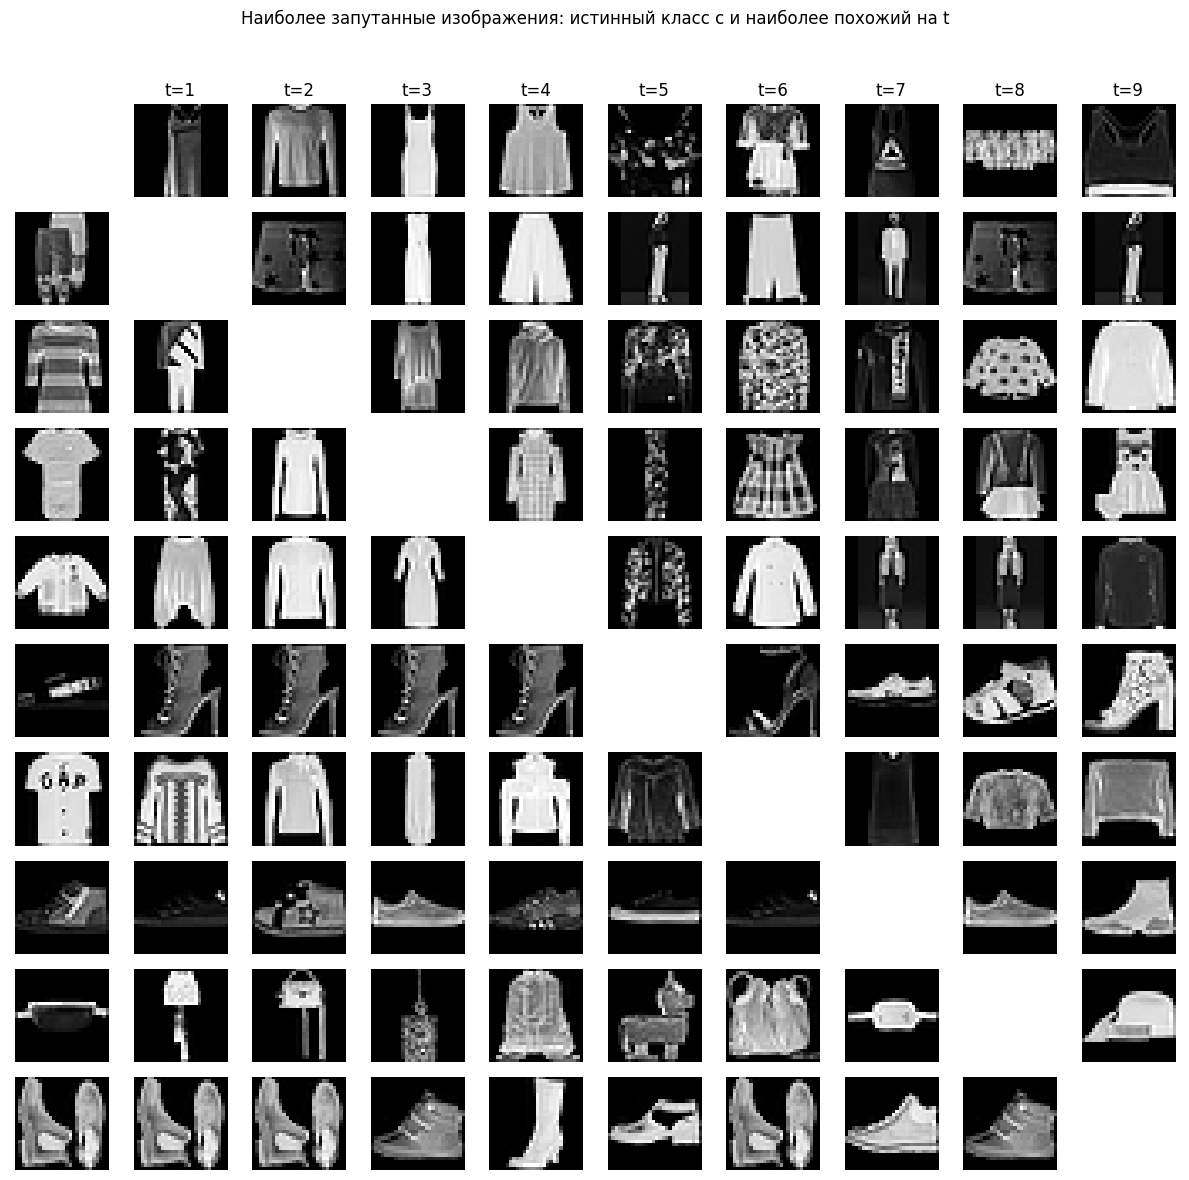

In [9]:
# Получение предсказаний для тестового набора FashionMNIST
model.eval()
probs = []  # будет хранить вероятности softmax
labels_list = []

with torch.no_grad():
    for images, labels in fashion_test_loader:
        images = images.to(device)
        outputs = model(images, head='head2')
        softmax_probs = torch.softmax(outputs, dim=1)
        probs.append(softmax_probs.cpu().numpy())
        labels_list.append(labels.numpy())

probs = np.vstack(probs)
labels_array = np.concatenate(labels_list)

# Для каждого истинного класса c и целевого класса t найдите индекс изображения с наибольшей вероятностью для t среди изображений класса c
num_classes = 10
similar_indices = np.zeros((num_classes, num_classes), dtype=int)

for c in range(num_classes):
    class_mask = labels_array == c
    for t in range(num_classes):
        if c == t:
            similar_indices[c, t] = -1  # пропустить самих себя
        else:
            class_probs = probs[class_mask, t]
            if class_probs.size > 0:
                idx_within_class = np.argmax(class_probs)
                indices = np.where(class_mask)[0]
                similar_indices[c, t] = indices[idx_within_class]

# Отображение сетки изображений
fig, axes = plt.subplots(num_classes, num_classes, figsize=(12, 12))
for c in range(num_classes):
    for t in range(num_classes):
        ax = axes[c, t]
        ax.axis('off')
        if c == t:
            continue
        idx = similar_indices[c, t]
        img, _ = fashion_test[idx]
        ax.imshow(img.squeeze(), cmap='gray')
        if c == 0:
            ax.set_title(f"t={t}")
        if t == 0:
            ax.set_ylabel(f"c={c}")

plt.suptitle('Наиболее запутанные изображения: истинный класс c и наиболее похожий на t')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
